# Setup

In [83]:
%%capture

%load_ext autoreload
%autoreload 2

!pip install filterpy

In [84]:
import numpy as np
import pandas as pd
import os
import sys
from tqdm import tqdm
from filterpy.kalman import EnsembleKalmanFilter as EnKF
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.interpolate import griddata
import jax


In [85]:
if os.path.isdir('./ACM270_Model_Error/') == False:
    ! git clone https://github.com/sreemanti-dey/ACM270_Model_Error.git
sys.path.append('./ACM270_Model_Error/')

! cd ACM270_Model_Error

dt = 0.1  # time step
noise_const = 0.1
file = f"ACM270_Model_Error/testing_data_noise_{noise_const}_dt_{dt}.npz"
np.load(file)

NpzFile 'ACM270_Model_Error/testing_data_noise_0.1_dt_0.1.npz' with keys: forecast, analysis, true_trajectory, noisy_trajectory, time

# True Trajectory and Noisy Observations with 2-Scale Lorenz96

In [86]:
import jax
import jax.numpy as jnp
from jax import jit,random

# parameters for two-scale L96
K = 5                   # number of large scale vars
J = 2                      # number of small scale vars per large var
h = 0.25                   # part of coupling
c = 10                     # part of coupling
b = 10                     # part of coupling
F = 10                     # forcing
dt = 0.05                  # time step
num_steps = 2000
time_steps = num_steps

@jit
def L96_2(xy):
    x = xy[0:K]
    y = xy[K:].reshape(K, J)

    dx = jnp.zeros(K)
    dy = jnp.zeros((K, J))

    for k in range(K):
        dxdt = -1 * x[k - 1] * (x[k - 2] - x[(k + 1) % K]) - x[k] + F - (h * c / b) * jnp.sum(y[k])
        dx = dx.at[k].set(dxdt)

        for j in range(J):
            dydt = -1 * c * b * y[k, (j + 1) % J] * (y[k, (j + 2) % J] - y[k, j - 1]) - c * y[k, j] + (h * c / b) * x[k]
            dy = dy.at[k, j].set(dydt)

    return jnp.concatenate([dx, dy.flatten()])

@jit
def rk4_step_lorenz96_2(x):
    f = lambda y: L96_2(y)
    k1 = dt * f(x)
    k2 = dt * f(x + k1/2)
    k3 = dt * f(x + k2/2)
    k4 = dt * f(x + k3)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

keys = iter(random.split(random.PRNGKey(0), 10))
key = random.PRNGKey(0)
# randomized starting point for large scale, 0 for small scale
x0 = np.linspace(0, 1, K)  # np.random.rand(K)
y0 = np.zeros((K, J))
xy0 = np.concatenate([x0, y0.flatten()])

rk4_step_lorenz96_2(xy0)


Array([0.4580462 , 0.72024274, 0.98136723, 1.2270589 , 1.414112  ,
       0.00247395, 0.00247395, 0.00499661, 0.00499661, 0.00749014,
       0.00749014, 0.00992735, 0.00992735, 0.01207061, 0.01207061],      dtype=float32)

In [120]:
trajectory = jnp.zeros((time_steps, len(xy0)))
noisy_obs = jnp.zeros((time_steps, len(xy0)))
noise_covar = jnp.eye(len(xy0)) * 0.1

xy = xy0
for i in tqdm(range(time_steps)):
    xy = rk4_step_lorenz96_2(xy)
    trajectory = trajectory.at[i].set(xy)
    # Add noise to the observations
    noise = random.multivariate_normal(key, jnp.zeros(len(xy0)), noise_covar)
    noisy_obs = noisy_obs.at[i].set(xy + noise)
    key, _ = random.split(key)  # Update key for the next iteration



100%|██████████| 2000/2000 [00:05<00:00, 398.32it/s]


## True Trajectory

In [88]:
np.save("true_trajectory.npy", trajectory)
np.save("noisy_obs.npy", noisy_obs)

# EnKF for 1-Scale Assimilation

In [89]:
@jit
def rk4_step_lorenz96_1(x):
    f = lambda y: (jnp.roll(y, 1) - jnp.roll(y, -2)) * jnp.roll(y, -1) - y + F
    k1 = dt * f(x)
    k2 = dt * f(x + k1/2)
    k3 = dt * f(x + k2/2)
    k4 = dt * f(x + k3)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

from jax.tree_util import Partial
from functools import partial
lorenz1 = Partial(rk4_step_lorenz96_1)
lorenz2 = Partial(rk4_step_lorenz96_2)

In [90]:
import jax
import jax.numpy as jnp
from jax import jit, random, lax
from jax.scipy.linalg import sqrtm
from functools import partial
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy import integrate

@jit
def ledoit_wolf(P, shrinkage):
    return (1 - shrinkage) * P + shrinkage * jnp.trace(P) / P.shape[0] * jnp.eye(P.shape[0])

@jit
def ensrf_step(ensemble, y, H, Q, R, key, inflation = 1.2):
    n_ensemble = ensemble.shape[1]
    x_m = jnp.mean(ensemble, axis=1)
    A = ensemble - x_m.reshape((-1, 1))
    C_pred = (A @ A.T) / (n_ensemble - 1) + Q
    C_pred = ledoit_wolf(C_pred, 0.1)
    A = A * inflation
    P =  (A @ A.T) / (n_ensemble - 1) + Q
    K = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)
    x_m += K @ (y - H @ x_m)
    M_sqrt = sqrt_m(jnp.eye(x_m.shape[0]) - K @ H)
    updated_A = M_sqrt @ A
    updated_ensemble = x_m.reshape((-1, 1)) + updated_A
    updated_P = (updated_A @ updated_A.T) / (n_ensemble - 1)
    updated_P = ledoit_wolf(updated_P, 0.1)

    ensemble = ensemble.astype(jnp.float32)
    C_pred = C_pred.astype(jnp.float32)
    updated_ensemble = updated_ensemble.astype(jnp.float32)
    updated_P = updated_P.astype(jnp.float32)
    return ensemble, C_pred, updated_ensemble, updated_P

@jit
def sqrt_m(M):
    eigenvalues, eigenvectors = jnp.linalg.eigh(M)
    inv_sqrt_eigenvalues = jnp.sqrt(eigenvalues)
    Lambda_inv_sqrt = jnp.diag(inv_sqrt_eigenvalues)
    M_sqrt = eigenvectors @ Lambda_inv_sqrt @ eigenvectors.T
    return M_sqrt.real

@partial(jit, static_argnums=(3))
def ensrf_steps(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, key):
    model_vmap = jax.vmap(lambda v: state_transition_function(v), in_axes=1, out_axes=1)
    key, *subkeys = random.split(key, num=num_steps + 1)
    subkeys = jnp.array(subkeys)

    def inner(carry, t):
        ensemble, covar = carry
        ensemble_predicted = model_vmap(ensemble)
        _, C_forecast, ensemble_analysis, C_analysis = ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, subkeys[t])
        return (ensemble_analysis, C_analysis), (ensemble_predicted, C_forecast, ensemble_analysis, C_analysis)

    n = len(Q[0])
    covariance_init = jnp.zeros((n, n))
    _, (ensemble_forecast, C_forecast, ensemble_analysis, C_analysis) = jax.lax.scan(inner, (ensemble_init, covariance_init), jnp.arange(num_steps))

    return ensemble_forecast, C_forecast, ensemble_analysis, C_analysis

In [121]:
Q = 0.1 * jnp.eye(K)
H = jnp.eye(K)
R = jnp.eye(K) * 0.1
n_ensemble = 100
num_steps = time_steps
#the ensrf (ENKF) will run single scale Lorenz on the first K variables
observations = noisy_obs[:,:K]
initial_state = np.zeros((1, K))
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
ensemble_forecast, C_forecast, ensemble_analysis, C_analysis = ensrf_steps(lorenz1, n_ensemble, ensemble_init, time_steps, observations, 1, H, Q, R, key)


In [92]:
@jit
def log_likelihood(y, H, R, mean_seq, cov_seq):
    def log_likelihood_j(carry, inputs):
        mean_j, cov_j, y_j = inputs
        error = y_j - H @ mean_j
        S_j = H @ cov_j @ H.T + R
        S_j_inv = jnp.linalg.inv(S_j)
        ll = -0.5 * (error.T @ S_j_inv @ error + jnp.log(jnp.linalg.det(S_j)))
        return carry + ll, ll

    inputs = (mean_seq[1:], cov_seq[1:], y[1:])
    initial_carry = 0.0
    log_likelihood, _ = lax.scan(log_likelihood_j, initial_carry, inputs)

    return log_likelihood


In [122]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

class NeuralNetCorrection(nn.Module):
    features: int
    @nn.compact
    def __call__(self, x, train=True):
        # x = nn.Dense(self.features, kernel_init=nn.initializers.he_normal())(x)
        x = nn.Dense(self.features, kernel_init=nn.initializers.he_normal())(x)
        x = nn.Dense(x.shape[-1], kernel_init=nn.initializers.he_normal())(x)  # Output layer
        return x

def create_model(key, input_shape, features):
    model = NeuralNetCorrection(features)
    params = model.init(key, jnp.ones(input_shape))['params']
    return model, params

def update_state(state, grads):
    grads = jax.tree_util.tree_map(lambda g: jnp.nan_to_num(g, nan=0.0, posinf=0.0, neginf=0.0), grads)
    return state.apply_gradients(grads=grads)

key = jax.random.PRNGKey(0)
features = K
input_shape = (K,)
model, params = create_model(key, input_shape, features)


In [123]:
@partial(jit, static_argnums=(3))
def ensrf_steps_nn(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, key, nn_params):
    model_vmap = jax.vmap(lambda v: state_transition_function(v) + model.apply({'params': nn_params}, state_transition_function(v)), in_axes=1, out_axes=1)
    key, *subkeys = random.split(key, num=num_steps + 1)
    subkeys = jnp.array(subkeys)
    def inner(carry, t):
        ensemble, covar = carry
        ensemble_predicted = model_vmap(ensemble)
        _, C_forecast, ensemble_analysis, C_analysis = ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, subkeys[t])
        return (ensemble_analysis, C_analysis), (ensemble_predicted, C_forecast, ensemble_analysis, C_analysis)
    n = len(Q[0])
    covariance_init = jnp.zeros((n, n))
    _, (ensemble_forecast, C_forecast, ensemble_analysis, C_analysis) = jax.lax.scan(inner, (ensemble_init, covariance_init), jnp.arange(num_steps))

    return ensemble_forecast, C_forecast, ensemble_analysis, C_analysis

In [124]:
def objective_fn(params):
    # Run the ensemble Kalman filter steps with the current parameters
    ensemble_forecast, C_forecast, ensemble_analysis, C_analysis = ensrf_steps_nn(
        lorenz1, n_ensemble, ensemble_init, time_steps, observations, 1, H, Q, R, key, params)
    # Calculate the log-likelihood for the forecast
    an_mean_seq = jnp.mean(ensemble_analysis, axis=2)
    an_cov_seq = C_analysis
    nll = -log_likelihood(observations, H, R, an_mean_seq, an_cov_seq)
    return nll

In [125]:
from jax import grad
learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
model, params = create_model(key, input_shape, features)

state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

num_iterations = 50
log_likelihoods = []
saved_params = []


for iteration in range(num_iterations):

    grads = grad(objective_fn)(state.params)
    state = update_state(state, grads)
    saved_params.append(state.params)

    current_log_likelihood = -objective_fn(state.params)
    log_likelihoods.append(current_log_likelihood)
    print(f"Iteration {iteration + 1}, Log-Likelihood: {current_log_likelihood}")

final_params = state.params


Iteration 1, Log-Likelihood: -151971.875
Iteration 2, Log-Likelihood: -145120.78125
Iteration 3, Log-Likelihood: -139583.234375
Iteration 4, Log-Likelihood: -133572.28125
Iteration 5, Log-Likelihood: -127910.6484375
Iteration 6, Log-Likelihood: -121871.078125
Iteration 7, Log-Likelihood: -116669.46875
Iteration 8, Log-Likelihood: -111381.0703125
Iteration 9, Log-Likelihood: -106400.8203125
Iteration 10, Log-Likelihood: -101530.9140625
Iteration 11, Log-Likelihood: -97320.6171875
Iteration 12, Log-Likelihood: -93106.9921875
Iteration 13, Log-Likelihood: -89882.0625
Iteration 14, Log-Likelihood: -86906.21875
Iteration 15, Log-Likelihood: -84861.53125
Iteration 16, Log-Likelihood: -82903.0234375
Iteration 17, Log-Likelihood: -81752.9921875
Iteration 18, Log-Likelihood: -81685.1171875
Iteration 19, Log-Likelihood: -81992.8046875
Iteration 20, Log-Likelihood: -81705.390625
Iteration 21, Log-Likelihood: -80885.609375
Iteration 22, Log-Likelihood: -79826.953125
Iteration 23, Log-Likelihood: -

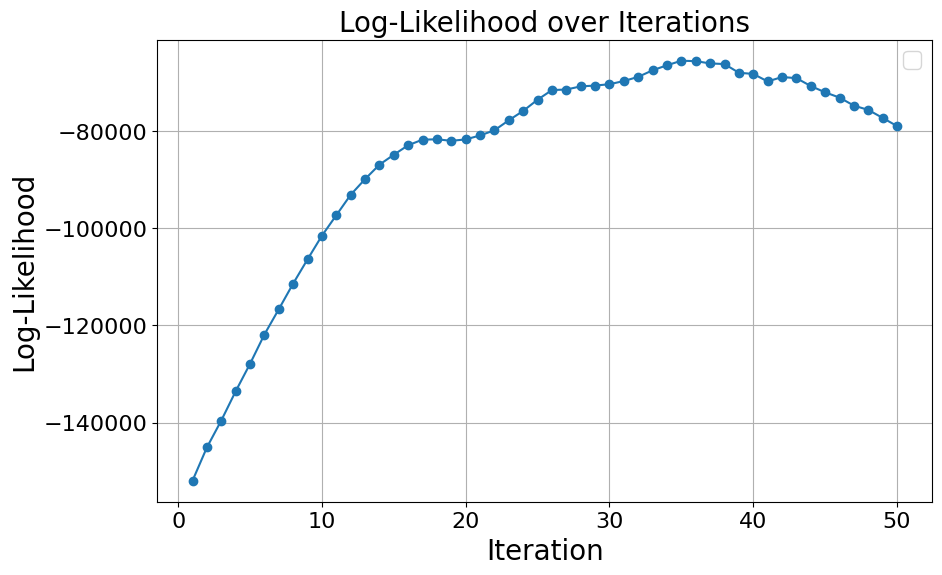

In [144]:

fontsize = 20

res = 300  # DPI for the saved image

plt.figure(figsize=(10, 6))

plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("Log-Likelihood", fontsize=fontsize)
plt.title("Log-Likelihood over Iterations", fontsize=fontsize)
plt.legend(["Log-Likelihood"], fontsize=fontsize / 1.25)
plt.grid(True)
plt.xticks(fontsize=fontsize / 1.25)
plt.yticks(fontsize=fontsize / 1.25)

# # Saving the figure with specific settings
# plt.savefig(f"MSE_vs_LR_noise_{noise_const}_dt_{dt}.png", bbox_inches="tight", dpi=res)

# # Show the plot

plt.plot(range(1, num_iterations + 1), log_likelihoods, marker='o', linestyle='-')
# plt.xlabel('Iteration')
# plt.ylabel('Log-Likelihood')
# plt.title('Log-Likelihood over Iterations',fontsize=20)
# plt.grid(True)
plt.show()

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
def ensrf_steps_nn(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, key, nn_params):
    model_vmap = jax.vmap(lambda v: state_transition_function(v) + model.apply({'params': nn_params}, state_transition_function(v)), in_axes=1, out_axes=1)
    key, *subkeys = random.split(key, num=num_steps + 1)
    subkeys = jnp.array(subkeys)
    def inner(carry, t):
        ensemble, covar = carry
        ensemble_predicted = model_vmap(ensemble)
        _, C_forecast, ensemble_analysis, C_analysis = ensrf_step(ensemble_predicted, observations[t, :], H, Q, R, subkeys[t])
        return (ensemble_analysis, C_analysis), (ensemble_predicted, C_forecast, ensemble_analysis, C_analysis)
    n = len(Q[0])
    covariance_init = jnp.zeros((n, n))
    _, (ensemble_forecast, C_forecast, ensemble_analysis, C_analysis) = jax.lax.scan(inner, (ensemble_init, covariance_init), jnp.arange(num_steps))

    return ensemble_forecast, C_forecast, ensemble_analysis, C_analysis



In [100]:
# nn_params = state.params
# ensemble_forecast_NN, C_forecast_NN, ensemble_analysis_NN, C_analysis_NN = ensrf_steps_nn(
#     lorenz1,
#     n_ensemble,
#     ensemble_init,
#     time_steps,
#     observations,
#     1,
#     H,
#     Q,
#     R,
#     key,
#     nn_params
# )

# ensemble_forecast, C_forecast, ensemble_analysis, C_analysis = ensrf_steps(
#     lorenz1,
#     n_ensemble,
#     ensemble_init,
#     time_steps,
#     observations,
#     1,
#     H,
#     Q,
#     R,
#     key
# )

# time_steps = ensemble_forecast.shape[0]
# time = jnp.arange(time_steps)

# true_states = trajectory
# forecast_means = jnp.mean(ensemble_forecast, axis=2)
# analysis_means = jnp.mean(ensemble_analysis, axis=2)

# forecast_means_NN = jnp.mean(ensemble_forecast_NN, axis=2)
# analysis_means_NN = jnp.mean(ensemble_analysis_NN, axis=2)

# plt.figure(figsize=(14, 8))

# i = 0  # Index of the state variable to plot
# plt.plot(time, true_states[:, i], label=f"True state {i+1}", linestyle="-", marker="o")
# plt.plot(time, forecast_means[:, i], label=f"Forecast mean {i+1} (uncorrected)", linestyle="--", marker="x")
# plt.plot(time, analysis_means[:, i], label=f"Analysis mean {i+1} (uncorrected)", linestyle="--", marker="x")
# plt.plot(time, forecast_means_NN[:, i], label=f"Forecast mean {i+1} (corrected)", linestyle=":", marker="d")
# plt.plot(time, analysis_means_NN[:, i], label=f"Analysis mean {i+1} (corrected)", linestyle=":", marker="d")
# plt.scatter(time, observations[:, i], label=f"Observations {i+1}", marker="s")

# plt.xlabel("Time steps")
# plt.ylabel("State values")
# plt.title("Comparison of Forecast and Analysis Means with True State and Observations")
# plt.legend()
# plt.grid(True)
# plt.show()

In [102]:
true_states_np = np.array(trajectory)

In [133]:
trajectory[:,K:].shape

(2000, 10)

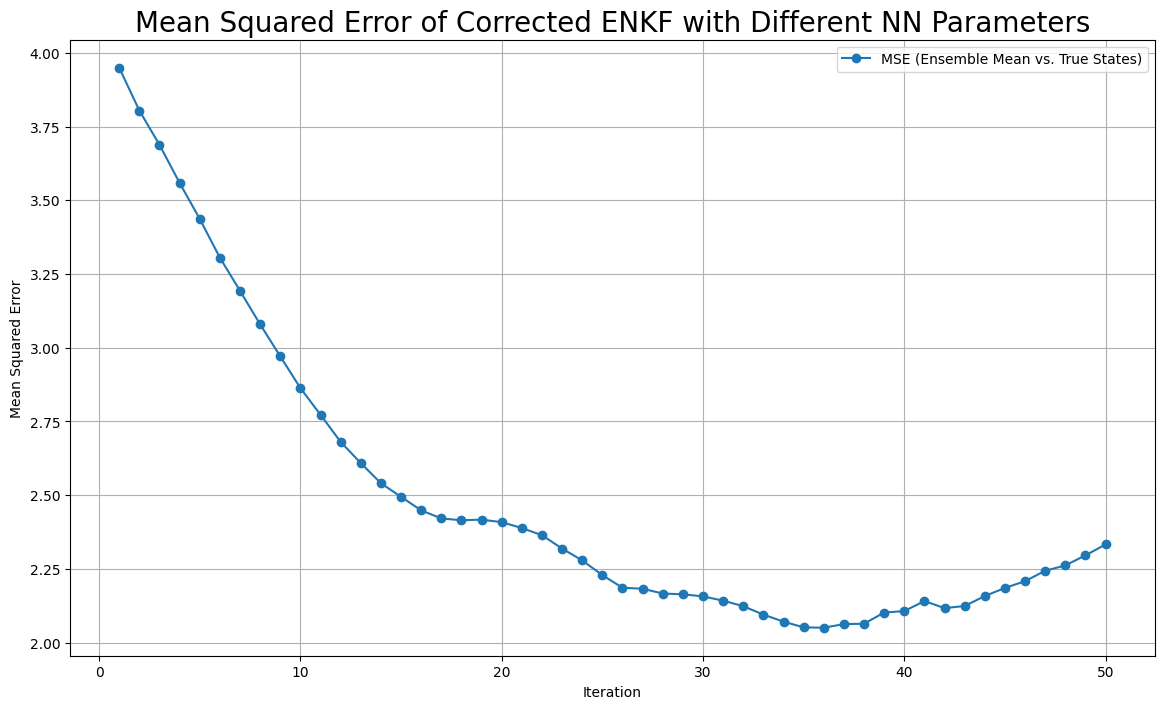

MSE Statistics (Corrected at each iteration):
Mean: 2.4887001514434814
Standard Deviation: 0.5005273222923279


In [139]:
import numpy as np
import matplotlib.pyplot as plt

mse_values = []

for params in saved_params:
    ensemble_forecast_NN, C_forecast_NN, ensemble_analysis_NN, C_analysis_NN = ensrf_steps_nn(
        lorenz1,
        n_ensemble,
        ensemble_init,
        time_steps,
        observations,
        1,
        H,
        Q,
        R,
        key,
        params
    )
    ensemble_analysis_NN_np = np.array(ensemble_analysis_NN)

    # Calculate the ensemble mean predictions
    ensemble_mean_predictions = ensemble_analysis_NN_np.mean(axis=2)



    # Calculate MSE between the ensemble mean and the true observed states
    mse = ((ensemble_mean_predictions - trajectory[:,:K]) ** 2).mean()
    mse_values.append(mse)



MSE Statistics (Corrected at each iteration):
Mean: 2.4887001514434814
Standard Deviation: 0.5005273222923279


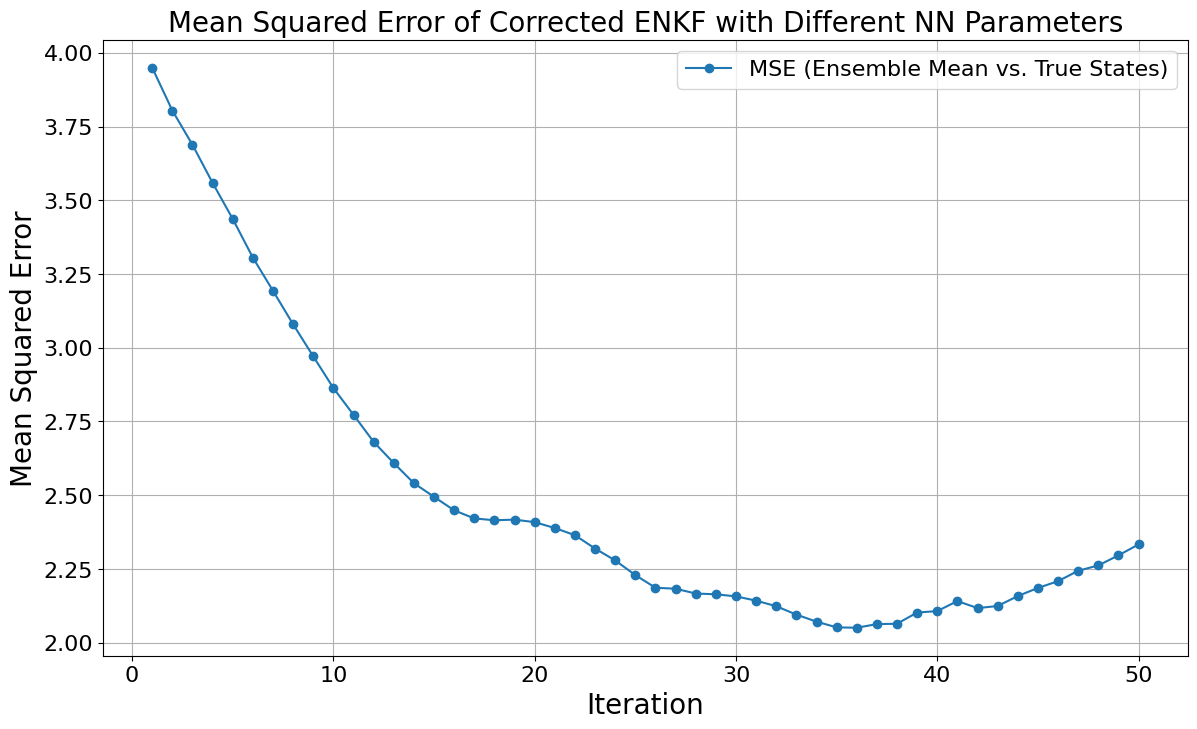

In [145]:

# Plot the MSE over iterations
iterations = np.arange(1, len(mse_values) + 1)

plt.figure(figsize=(14, 8))
plt.plot(iterations, mse_values, label="MSE (Ensemble Mean vs. True States)", linestyle="-", marker="o")

plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("Mean Squared Error", fontsize=fontsize)
plt.title("Mean Squared Error of Corrected ENKF with Different NN Parameters", fontsize=fontsize)
plt.legend(fontsize=fontsize / 1.25)
plt.grid(True)
plt.xticks(fontsize=fontsize / 1.25)
plt.yticks(fontsize=fontsize / 1.25)


print("MSE Statistics (Corrected at each iteration):")
print(f"Mean: {np.mean(mse_values)}")
print(f"Standard Deviation: {np.std(mse_values)}")

In [114]:
import numpy as np
import jax.numpy as jnp

# Define the noise constants and dt values
noise_consts = [0.1, 0.5, 1, 5]
dts = [0.01, 0.05, 0.075, 0.1]

def load_data(noise, dt):
    filename = f'/content/drive/MyDrive/ACM270_Model_Error-main/k5_testing_data_noise_{noise}_dt_{dt}.npz'
    return np.load(filename)


results = {}
for noise in noise_consts:
    for dt in dts:
        data = load_data(noise, dt)

        observations1 = jnp.array(data['noisy_trajectory'])
        true_trajectory = data['true_trajectory']

        mse_values = []

        for i in range(observations1.shape[2]):
            # Isolate the i-th trajectory across all time points
            single_observation = observations1[:, :, i]
            single_trajectory = true_trajectory[:,:,i]

            ensemble_forecast_NN, C_forecast_NN, ensemble_analysis_NN, C_analysis_NN = ensrf_steps_nn(
                lorenz1, n_ensemble, ensemble_init, len(single_observation), single_observation, 1, H, Q, R, key, final_params)

            ensemble_analysis_NN_np = np.array(ensemble_analysis_NN).mean(axis = 2)


            mse = ((ensemble_analysis_NN_np - single_trajectory) ** 2).mean()

            mse_values.append(mse)

        results[(noise, dt)] = {'Average MSE': np.mean(mse_values)}

print(results)


<ipython-input-114-989b1490bf77>:34: RuntimeWarning: invalid value encountered in subtract
  mse = ((ensemble_analysis_NN_np - single_trajectory) ** 2).mean()
<ipython-input-114-989b1490bf77>:34: RuntimeWarning: invalid value encountered in subtract
  mse = ((ensemble_analysis_NN_np - single_trajectory) ** 2).mean()


{(0.1, 0.01): {'Average MSE': 1.7766878018924757}, (0.1, 0.05): {'Average MSE': 2.250378322836265}, (0.1, 0.075): {'Average MSE': nan}, (0.1, 0.1): {'Average MSE': nan}, (0.5, 0.01): {'Average MSE': 2.380727783683956}, (0.5, 0.05): {'Average MSE': 2.522784644437233}, (0.5, 0.075): {'Average MSE': nan}, (0.5, 0.1): {'Average MSE': nan}, (1, 0.01): {'Average MSE': 3.5758670807006054}, (1, 0.05): {'Average MSE': 2.790671390531802}, (1, 0.075): {'Average MSE': 2.979600296388153}, (1, 0.1): {'Average MSE': nan}, (5, 0.01): {'Average MSE': 4.693008023621079}, (5, 0.05): {'Average MSE': 5.7136882947337515}, (5, 0.075): {'Average MSE': nan}, (5, 0.1): {'Average MSE': nan}}


In [119]:
import pandas as pd
pd.DataFrame(results).to_csv('results')